# Validación de modelo con curvas clasificadas

Este notebook carga el archivo CSV con curvas clasificadas, pivotea los datos y genera matrices de confusión
para comparar curvas de registros vs curvas de inversión sísmica. Incluye tolerancia en la alineación.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Ruta del archivo CSV
csv_path = "/workspaces/ml-bootcamp-labs/data/raw/CURVAS_CLASIFICADAS_CVS.csv"

# Leer CSV con separador ;
df = pd.read_csv(csv_path, sep=';')
df.head()

,Profundidad,Valor,Tipo,Pozo
0,5005,3,RT3_POR,LLANITO-121
1,5006,3,RT3_POR,LLANITO-121
2,5006,2,RT3_POR,LLANITO-121
3,5007,1,RT3_POR,LLANITO-121
4,5007,1,RT3_POR,LLANITO-121


In [2]:
# Pivotear para tener columnas por curva
df_pivot = df.pivot_table(index=["Profundidad", "Pozo"], 
                          columns="Tipo", 
                          values="Valor", 
                          aggfunc="first").reset_index()

# Eliminar multi-índice de columnas
df_pivot.columns.name = None
df_pivot.head(15)

,Profundidad,Pozo,RT3_IP,RT3_K,RT3_POR,RT3_VPVS,RT3_VSH,RT3_XPLT
0,5000,LLANITO-121,NaN,NaN,NaN,NaN,1.0,NaN
1,5001,LLANITO-121,NaN,NaN,NaN,NaN,2.0,NaN
2,5002,LLANITO-121,NaN,NaN,NaN,NaN,1.0,NaN
3,5003,LLANITO-121,NaN,NaN,NaN,NaN,2.0,NaN
4,5004,LLANITO-121,NaN,NaN,NaN,NaN,2.0,NaN
5,5005,LLANITO-121,NaN,NaN,3.0,NaN,3.0,NaN
6,5006,LLANITO-121,NaN,NaN,3.0,NaN,3.0,NaN
7,5007,LLANITO-121,NaN,NaN,1.0,NaN,2.0,NaN
8,5008,LLANITO-121,NaN,NaN,1.0,NaN,2.0,NaN
9,5009,LLANITO-121,NaN,NaN,1.0,NaN,2.0,NaN


In [3]:
# Definir curvas de registros (ground truth) y de inversión (predicciones)
curvas_gt = ["RT3_K", "RT3_POR", "RT3_VSH"]
curvas_pred = ["RT3_VPVS", "RT3_IP", "RT3_XPLT"]

# Definir tolerancia en ft
tolerancia = 33

def alinear_con_tolerancia(df, curva_gt, curva_pred, tolerancia=33):
    df_gt = df[["Profundidad", curva_gt]].dropna().copy()
    df_pred = df[["Profundidad", curva_pred]].dropna().copy()

    pares = []
    for _, row in df_gt.iterrows():
        prof = row["Profundidad"]
        val_gt = row[curva_gt]
        candidatos = df_pred[(df_pred["Profundidad"] >= prof - tolerancia) & 
                             (df_pred["Profundidad"] <= prof + tolerancia)]
        if not candidatos.empty:
            candidato = candidatos.iloc[(candidatos["Profundidad"] - prof).abs().argmin()]
            pares.append([val_gt, candidato[curva_pred]])

    if pares:
        return pd.DataFrame(pares, columns=["GT", "Pred"])
    else:
        return pd.DataFrame(columns=["GT", "Pred"])

Datos alineados:


,GT,Pred
0,3.0,1.0
1,3.0,1.0
2,3.0,1.0
3,3.0,1.0
4,3.0,1.0


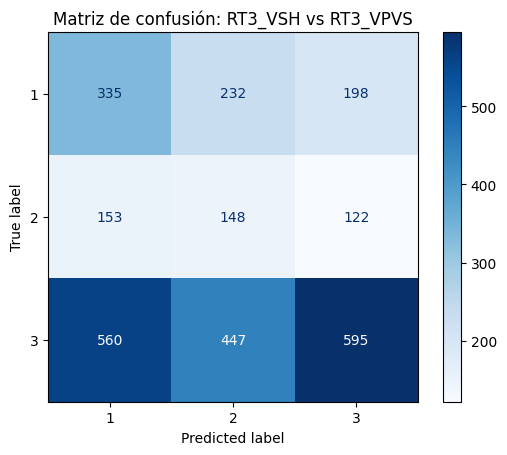

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.32      0.44      0.37       765
           2       0.18      0.35      0.24       423
           3       0.65      0.37      0.47      1602

    accuracy                           0.39      2790
   macro avg       0.38      0.39      0.36      2790
weighted avg       0.49      0.39      0.41      2790



In [4]:
# Ejemplo: correlacionar RT3_VSH (ground truth) vs RT3_VPVS (predicho)
curva_gt = "RT3_VSH"
curva_pred = "RT3_VPVS"

df_alineado = alinear_con_tolerancia(df_pivot, curva_gt, curva_pred, tolerancia)
print("Datos alineados:")
display(df_alineado.head())

if not df_alineado.empty:
    y_true = df_alineado["GT"].astype(int)
    y_pred = df_alineado["Pred"].astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[1,2,3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de confusión: {curva_gt} vs {curva_pred}")
    plt.show()

    print("Reporte de clasificación:")
    print(classification_report(y_true, y_pred, labels=[1,2,3]))
else:
    print(f"⚠️ No se encontraron datos alineados entre {curva_gt} y {curva_pred}.")